In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

%matplotlib notebook

In [2]:
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable


In [3]:
SEQUENCE_LENGTH=20
STOCKS = ['LLY', 'BMY', 'JNJ', 'ABBV', 'MRK', 'ZTS', 'PRGO', 'ELAN', 'TEVA', 'NVO']

### Training data prep

In [4]:
def get_vector(x):
    x = re.sub(r'(\(|\))', '', x)
    x = x.split(',')
    return [float(x1.strip()) for x1 in x]

In [5]:
df_tweets = pd.read_csv("data/tweet_stock_data.csv", index_col=False)
df_tweets['Tweet_Vector'] = df_tweets['Tweet Vector'].apply(lambda x: get_vector(x))
df_tweets['Date'] = pd.to_datetime(df_tweets['Date'], infer_datetime_format=True)
df_tweets['Year'] = df_tweets['Date'].apply(lambda x: x.year)
df_tweets['Month'] = df_tweets['Date'].apply(lambda x: x.month)
df_tweets['dayofweek'] = df_tweets['Date'].apply(lambda x: x.dayofweek)

cols = ['Date', 'Stock', 'Tweet_Vector', 'Year', 'Month', 'dayofweek']
df_tweets = df_tweets[cols]

In [6]:
df_tweets.head()

,Date,Stock,Tweet_Vector,Year,Month,dayofweek
0,2019-12-19,JNJ,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2019,12,3
1,2020-02-05,JNJ,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2020,2,2
2,2019-12-30,JNJ,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2019,12,0
3,2020-01-23,JNJ,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2020,1,3
4,2020-01-23,JNJ,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2020,1,3


In [7]:
len(df_tweets['Tweet_Vector'][0])

3228

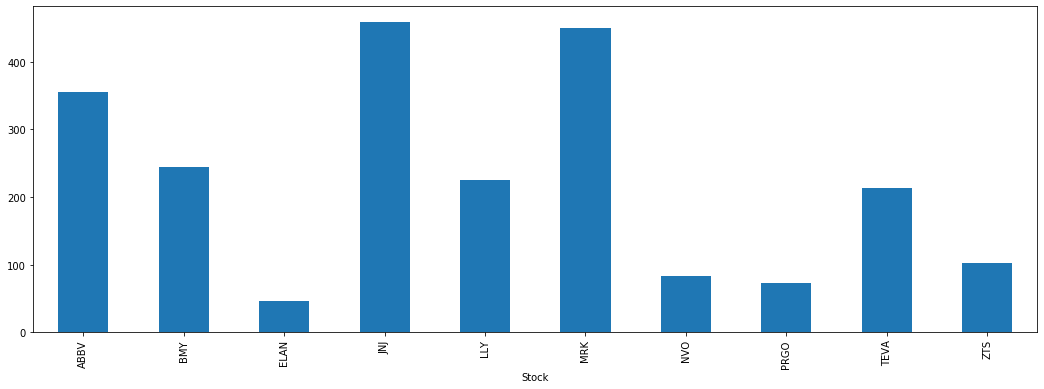

In [8]:
fig = plt.figure(figsize=(18,6))
df_tweets.groupby('Stock').Stock.count().plot.bar(ylim=0)
plt.show()


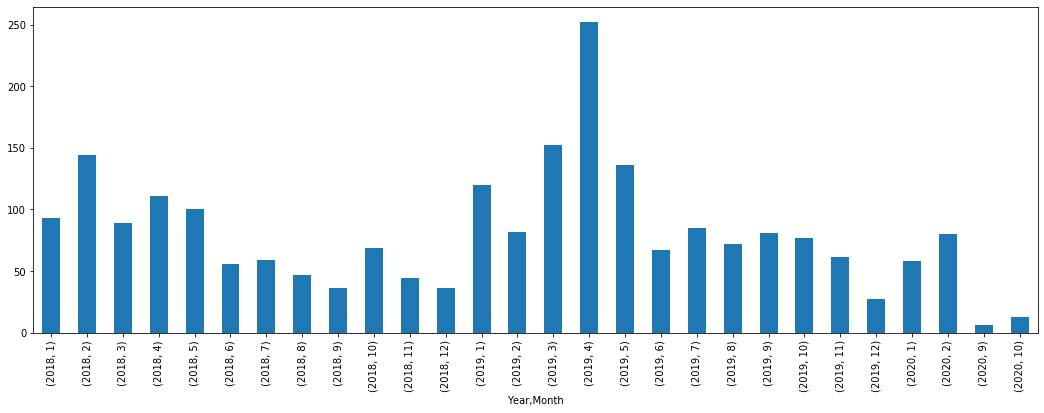

In [9]:
fig = plt.figure(figsize=(18,6))
df_tweets.groupby(['Year', 'Month']).Stock.count().plot.bar(ylim=0)
plt.show()

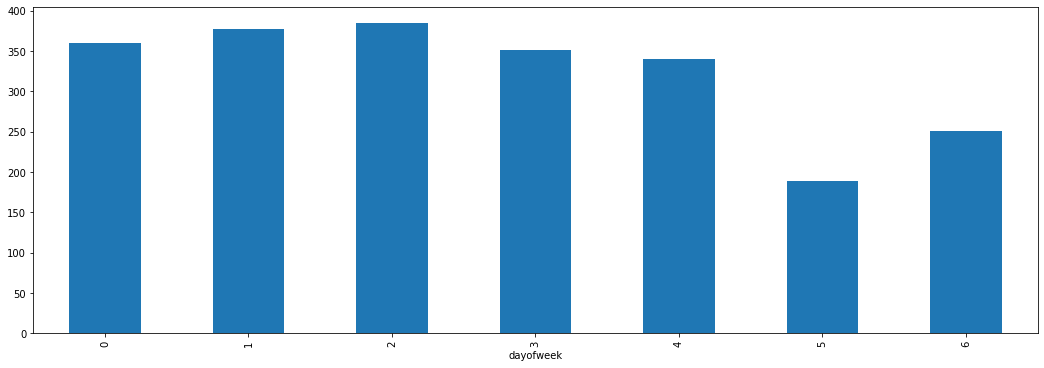

In [10]:
fig = plt.figure(figsize=(18,6))
df_tweets.groupby(['dayofweek']).Stock.count().plot.bar(ylim=0)
plt.show()

In [11]:
df_stocks = pd.read_csv("data/stock_data.csv", index_col=False)

df_stocks['Date'] = pd.to_datetime(df_stocks['Date'], infer_datetime_format=True)

df_stocks.drop(columns=['Unnamed: 0'], inplace=True)


In [12]:
df_stocks.head()

,Stock,Date,Open,Close,High,Low,Volume
0,LLY,2018-01-02,84.459999,84.680000,85.000000,84.059998,3456700
1,LLY,2018-01-03,84.739998,85.139999,85.419998,84.269997,3078400
2,LLY,2018-01-04,85.279999,85.519997,85.800003,84.739998,2462500
3,LLY,2018-01-05,86.089996,86.570000,86.750000,85.930000,2946300
4,LLY,2018-01-08,86.690002,86.129997,86.709999,85.400002,3251400


<Figure size 1296x432 with 0 Axes>

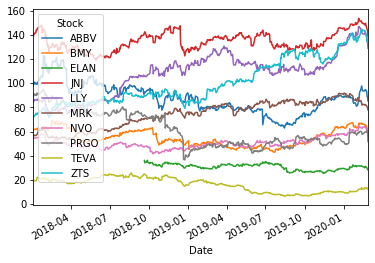

In [13]:
df = df_stocks[['Stock', 'Date', 'Close']]
                   
df = df.pivot_table('Close', ['Date'], 'Stock')

df.fillna(method='pad')

fig = plt.figure(figsize=(18,6))
               
#df.interpolate().plot()
df.plot()

plt.show()

In [14]:
df_stocks.head()

,Stock,Date,Open,Close,High,Low,Volume
0,LLY,2018-01-02,84.459999,84.680000,85.000000,84.059998,3456700
1,LLY,2018-01-03,84.739998,85.139999,85.419998,84.269997,3078400
2,LLY,2018-01-04,85.279999,85.519997,85.800003,84.739998,2462500
3,LLY,2018-01-05,86.089996,86.570000,86.750000,85.930000,2946300
4,LLY,2018-01-08,86.690002,86.129997,86.709999,85.400002,3251400


In [15]:
df = df_stocks.loc[df_stocks['Stock']=='LLY', ['Date', 'Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))
df = df.set_index('Date')
df.head()

,Close
Date,
2018-01-02,-0.713700
2018-01-03,-0.701121
2018-01-04,-0.690730
2018-01-05,-0.662018
2018-01-08,-0.674050


In [16]:
def load_data(df_stocks, stock):
    df = df_stocks.loc[df_stocks['Stock']==stock, ['Date', 'Close']]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))
    df = df.set_index('Date')
    
    data_raw = df.as_matrix()
    data = []
    
    # create sequences of length seq_len
    for index in range(len(data_raw) - SEQUENCE_LENGTH): 
        data.append(data_raw[index: index + SEQUENCE_LENGTH])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return x_train, y_train, x_test, y_test


In [17]:
x_data = False

for stock in STOCKS:
    x_train_, y_train_, x_test_, y_test_ = load_data(df_stocks, stock)
    if not x_data:
        x_data = True
        x_train = x_train_
        y_train = y_train_
        x_test = x_test_
        y_test = y_test_
    else:
        x_train = np.concatenate((x_train, x_train_))
        y_train = np.concatenate((y_train, y_train_))
        x_test = np.concatenate((x_test, x_test_))
        y_test = np.concatenate((y_test, y_test_))
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (4035, 19, 1)
y_train.shape =  (4035, 1)
x_test.shape =  (1004, 19, 1)
y_test.shape =  (1004, 1)


/anaconda3/envs/ravi36/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/anaconda3/envs/ravi36/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/anaconda3/envs/ravi36/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/anaconda3/envs/ravi36/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/anaconda3/envs/ravi36/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/anaconda3/envs/ravi36/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .a

In [18]:

# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [19]:
# Build model

input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
look_back=SEQUENCE_LENGTH

# Here we define our model as a class
class StockRebels(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(StockRebels, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # lstm layer1
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initialize
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        out, (hn, cn) = self.lstm1(x, (h0.detach(), c0.detach()))
        
        out = self.fc(out[:, -1, :]) 
        return out
    
model = StockRebels(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=True)

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

StockRebels(
  (lstm1): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


/anaconda3/envs/ravi36/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [20]:
batch_size = 128

train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [21]:
# Train model

num_epochs = 10
hist = np.zeros((num_epochs, 2))

for t in range(num_epochs):
    for x_train_, y_train_ in train_loader:
        optimiser.zero_grad()
        # Forward pass
        y_train_pred_ = model(x_train_)
        loss = loss_fn(y_train_pred_, y_train_)
        # Backward pass
        loss.backward()
        # Update parameters
        optimiser.step()    
    # Loss calculation
    y_train_pred = model(x_train)
    loss_train = loss_fn(y_train_pred, y_train)
    y_test_pred = model(x_test)
    loss_test = loss_fn(y_test_pred, y_test)
    print(f"Epoch {t}, Train MSE: {loss.item()}, Test MSE: {loss_test.item()}")
    hist[t][0] = loss.item()
    hist[t][1] = loss_test.item()

Epoch 0, Train MSE: 0.014695476740598679, Test MSE: 0.1032918319106102
Epoch 1, Train MSE: 0.023825209587812424, Test MSE: 0.028952671214938164
Epoch 2, Train MSE: 0.010881409980356693, Test MSE: 0.012931082397699356
Epoch 3, Train MSE: 0.006659814156591892, Test MSE: 0.006325307302176952
Epoch 4, Train MSE: 0.005367659963667393, Test MSE: 0.005444618873298168
Epoch 5, Train MSE: 0.004992871545255184, Test MSE: 0.004851296544075012
Epoch 6, Train MSE: 0.005269949324429035, Test MSE: 0.005377520341426134
Epoch 7, Train MSE: 0.005245518404990435, Test MSE: 0.005751392338424921
Epoch 8, Train MSE: 0.004973527044057846, Test MSE: 0.004533637780696154
Epoch 9, Train MSE: 0.0043467190116643906, Test MSE: 0.003748868126422167


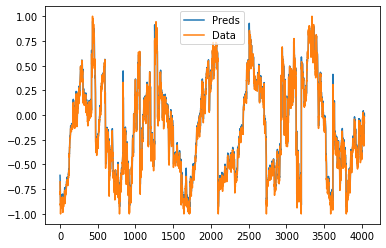

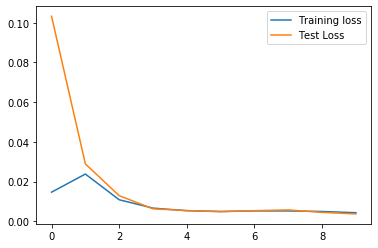

In [22]:
plt.plot(y_train_pred.detach().numpy(), label="Preds")
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(hist[:,0], label="Training loss")
plt.plot(hist[:,1], label="Test Loss")
plt.legend()
plt.show()

In [23]:
# make predictions  
y_test_pred = model(x_test)
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred.detach().numpy()[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

Test Score: 0.0612 RMSE
